In [1]:
###############################################################################################################
#                      In-vehicle coupon recommendation Project : Classification Model
#                                (c) Dr. Serkan Kaya - 1 April 2022
###############################################################################################################
#   Business Problem:
###############################################################################################################
# This project studies whether a person will accept the coupon recommended to him in different
# driving scenarios.
#
################################################################################################################
#   Dataset History
################################################################################################################
# This data was collected via a survey on Amazon Mechanical Turk. The survey describes
# different driving scenarios including the destination, current time, weather, passenger,
# etc., and then ask the person whether he will accept the coupon if he is the driver.
#
# Source:
# -------
# Tong Wang, tong-wang '@' uiowa.edu, University of Iowa
# Cynthia Rudin, cynthia '@' cs.duke.edu, Duke University

# For more information about the dataset, please refer to the paper:
# Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille.
# 'A bayesian framework for learning rule sets for interpretable classification.'
# The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.
#
################################################################################################################
#   Variables
################################################################################################################
# There 25 variables (+1 Target variable: 'Y' ) and 12684 observations.
#
# destination: No Urgent Place, Home, Work.
# passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car).
# weather: Sunny, Rainy, Snowy.
# temperature:55, 80, 30.
# time: 2PM, 10AM, 6PM, 7AM, 10PM.
# coupon: Restaurant(<$20), Coffee House, Carry out & Take away, Bar, Restaurant($20-$50).
# expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours).
# gender: Female, Male.
# age: 21, 46, 26, 31, 41, 50plus, 36, below21.
# maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed.
# has_Children: 1, 0.
# education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate,
#            Graduate degree (Masters or Doctorate), Some High School.
# occupation: Unemployed, Architecture & Engineering, Student, Education&Training&Library, Healthcare Support,
#             Healthcare Practitioners & Technical, Sales & Related, Management, Arts Design Entertainment Sports & Media,
#             Computer & Mathematical, Life Physical Social Science, Personal Care & Service, Community & Social Services,
#             Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair,
#             Transportation & Material Moving, Business & Financial, Protective Service, Food Preparation & Serving Related,
#             Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry.
# income: $37500 - $49999, $62500 - $74999, $12500 - $24999, $75000 - $87499, $50000 - $62499, $25000 - $37499, $100000 or More,
#         $87500 - $99999, Less than $12500.
# Bar: never, less1, 1~3, gt8, nan4~8 (feature meaning: how many times do you go to a bar every month?)
# CoffeeHouse: never, less1, 4~8, 1~3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)
# CarryAway: n4~8, 1~3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?)
# RestaurantLessThan20: 4~8, 1~3, less1, gt8, never
#                       (feature meaning: how many times do you go to a restaurant with an average expense per person of less than $20 every month?)
# Restaurant20To50: 1~3, less1, never, gt8, 4~8, nan
#                   (feature meaning: how many times do you go to a restaurant with average expense per person of $20 - $50 every month?)
# toCoupon_GEQ5min: 0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 5 minutes)
# toCoupon_GEQ15min: 0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes)
# toCoupon_GEQ25min: 0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes)
# direction_same: 0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)
# direction_opp: 1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)
# Y:1, 0 (whether the coupon is accepted)
#


In [2]:
############################################################################################
#   Importing Required Libraries
############################################################################################

In [6]:
!pip install plotly


     |████████████████████████████████| 27.7 MB 3.0 MB/s eta 0:00:01
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [7]:
!pip install catboost

  Using cached catboost-1.0.4-cp38-none-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (12.7 MB)
  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


In [8]:
!pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,  plot_roc_curve
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.expand_frame_repr', True)


In [24]:
############################################################################################
#                      Exploratory Data Analysis (E.D.A.)
############################################################################################
#   STEP 1: General View of the Dataset
############################################################################################

def load():
    data = pd.read_csv('in-vehicle-coupon-recommendation.csv')
    return data

df = load()

def check_df(dataframe, head=5):
    print('#################### Shape #########################')
    print(dataframe.shape)
    print('#################### Type ##########################')
    print(dataframe.dtypes)
    print('#################### Head #########################')
    print(dataframe.head(head))
    print('##################### Tail #########################')
    print(dataframe.tail(head))
    print('###################### NA ########################')
    print(dataframe.isnull().sum())
    print('###################### Quantile ########################')
    print(dataframe.quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_df(df) # General view of the dataset

# 'check_df' function shows the followings:
# There are 12684 observations and 26 variables
# Data type of each variable (or feature)
# Head and tail of the dataset
# Nbr of missing values for each variable
# Distribution of each variable in the dataset along the quantiles


#################### Shape #########################
(12684, 26)
#################### Type ##########################
destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object
#################### Head #########################
       des

In [25]:
############################################################################################
#   STEP 2 - EDA : Finding numerical and categorical variables
############################################################################################

def grab_col_names(dataframe, cat_th=10, car_th=26):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Nbr of class threshold value for variables having numerical appearance but they are categorical variables (numerically encoded)
        car_th: int, optional
                Nbr of class threshold for categorical variables but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variants with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = totol variables
        num_but_cat is already included in cat_cols.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat

# See the detailed docstring in the function above for the information about the parameters of the funcion.

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
print('\n')
print('Categorical variables => {}' .format(cat_cols),'\n')
print('Numerical variables => {}' .format(num_cols),'\n')
print('Categorical but cardinal variables => {}' .format(cat_but_car),'\n')
print('Numerical but categorical variables => {}' .format(num_but_cat),
      '''\n\nNOTE: In fact, these are categorical variables with having numerical apperances since they are encoded.
      Therefore, we will consider these variables in the cluster of categorical variables.''')

# Observations: 12684
# Variables: 26
# cat_cols: 26
# num_cols: 0
# cat_but_car: 0
# num_but_cat: 8
#
# Categorical variables => ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
#                           'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
#                           'Restaurant20To50', 'temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
#                           'direction_same', 'direction_opp', 'Y']
#
# Numerical variables => []
#                     => Note: 'temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp',
#                        'Y' are all categorical variables having numerical apperances since they are encoded. Therefore, we consider them in the cluster of characterical variables

# Categorical but cardinal variables => []


Observations: 12684
Variables: 26
cat_cols: 26
num_cols: 0
cat_but_car: 0
num_but_cat: 8


Categorical variables => ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'] 

Numerical variables => [] 

Categorical but cardinal variables => [] 

Numerical but categorical variables => ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'] 

NOTE: In fact, these are categorical variables with having numerical apperances since they are encoded.
      Therefore, we will consider these variables in the cluster of categorical variables.


                 destination  Ratio
No Urgent Place         6283 49.535
Home                    3237 25.520
Work                    3164 24.945
##########################################


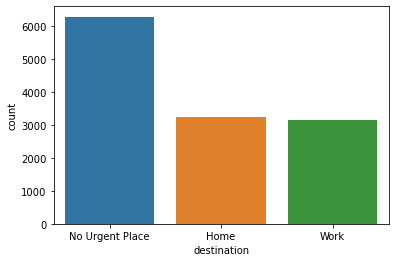

           passanger  Ratio
Alone           7305 57.592
Friend(s)       3298 26.001
Partner         1075  8.475
Kid(s)          1006  7.931
##########################################


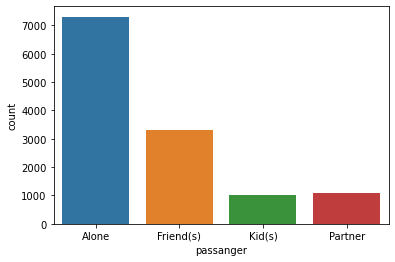

       weather  Ratio
Sunny    10069 79.383
Snowy     1405 11.077
Rainy     1210  9.540
##########################################


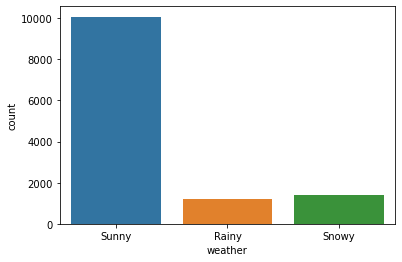

      time  Ratio
6PM   3230 25.465
7AM   3164 24.945
10AM  2275 17.936
2PM   2009 15.839
10PM  2006 15.815
##########################################


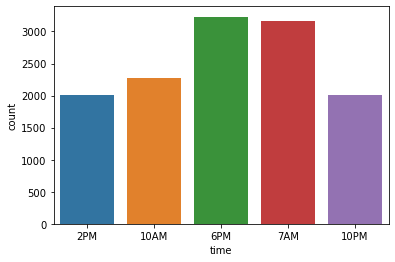

                       coupon  Ratio
Coffee House             3996 31.504
Restaurant(<20)          2786 21.965
Carry out & Take away    2393 18.866
Bar                      2017 15.902
Restaurant(20-50)        1492 11.763
##########################################


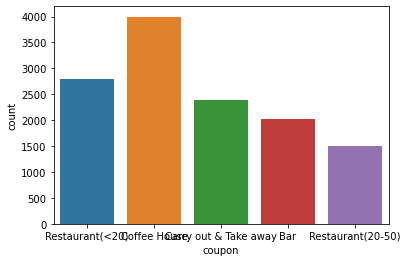

    expiration  Ratio
1d        7091 55.905
2h        5593 44.095
##########################################


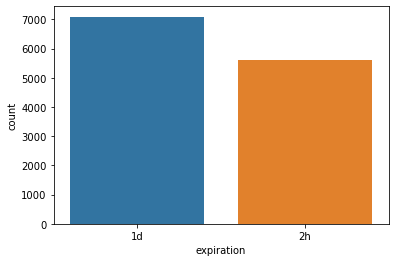

        gender  Ratio
Female    6511 51.332
Male      6173 48.668
##########################################


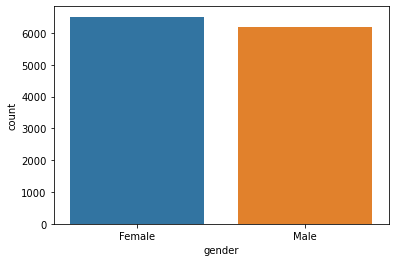

          age  Ratio
21       2653 20.916
26       2559 20.175
31       2039 16.075
50plus   1788 14.096
36       1319 10.399
41       1093  8.617
46        686  5.408
below21   547  4.313
##########################################


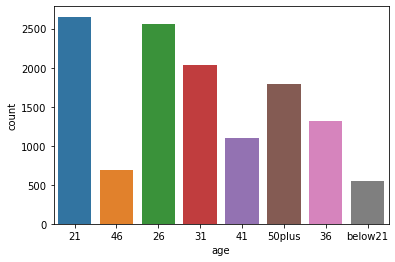

                   maritalStatus  Ratio
Married partner             5100 40.208
Single                      4752 37.465
Unmarried partner           2186 17.234
Divorced                     516  4.068
Widowed                      130  1.025
##########################################


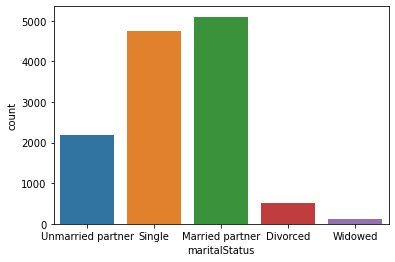

                                        education  Ratio
Some college - no degree                     4351 34.303
Bachelors degree                             4335 34.177
Graduate degree (Masters or Doctorate)       1852 14.601
Associates degree                            1153  9.090
High School Graduate                          905  7.135
Some High School                               88  0.694
##########################################


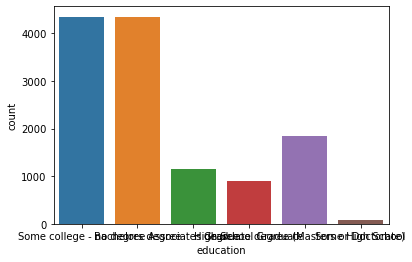

                                           occupation  Ratio
Unemployed                                       1870 14.743
Student                                          1584 12.488
Computer & Mathematical                          1408 11.101
Sales & Related                                  1093  8.617
Education&Training&Library                        943  7.435
Management                                        838  6.607
Office & Administrative Support                   639  5.038
Arts Design Entertainment Sports & Media          629  4.959
Business & Financial                              544  4.289
Retired                                           495  3.903
Food Preparation & Serving Related                298  2.349
Healthcare Practitioners & Technical              244  1.924
Healthcare Support                                242  1.908
Community & Social Services                       241  1.900
Legal                                             219  1.727
Transportation & Materia

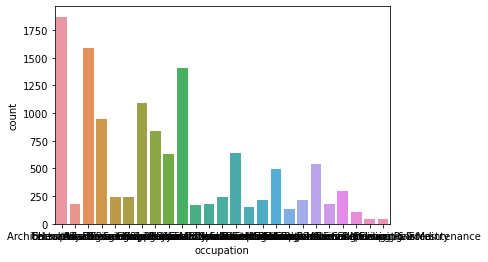

                  income  Ratio
$25000 - $37499     2013 15.870
$12500 - $24999     1831 14.436
$37500 - $49999     1805 14.231
$100000 or More     1736 13.687
$50000 - $62499     1659 13.079
Less than $12500    1042  8.215
$87500 - $99999      895  7.056
$75000 - $87499      857  6.757
$62500 - $74999      846  6.670
##########################################


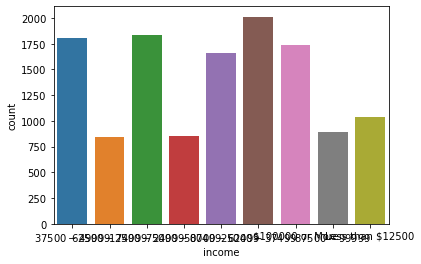

                                          car  Ratio
Scooter and motorcycle                     22  0.173
Mazda5                                     22  0.173
do not drive                               22  0.173
Car that is too old to install Onstar :D   21  0.166
crossover                                  21  0.166
##########################################


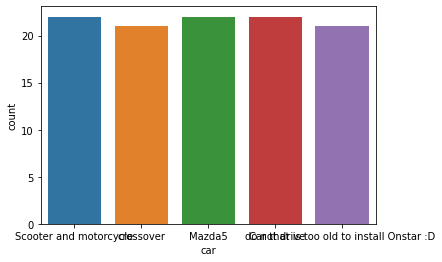

        Bar  Ratio
never  5197 40.973
less1  3482 27.452
1~3    2473 19.497
4~8    1076  8.483
gt8     349  2.751
##########################################


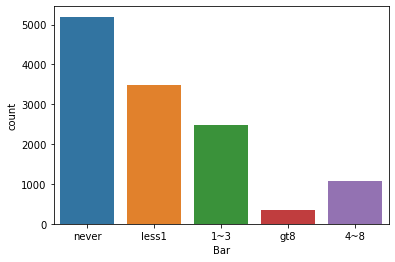

       CoffeeHouse  Ratio
less1         3385 26.687
1~3           3225 25.426
never         2962 23.352
4~8           1784 14.065
gt8           1111  8.759
##########################################


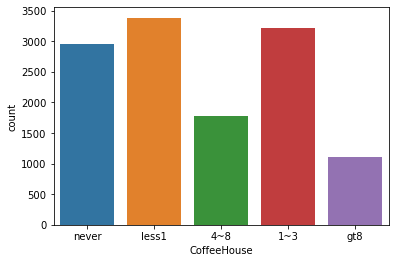

       CarryAway  Ratio
1~3         4672 36.834
4~8         4258 33.570
less1       1856 14.633
gt8         1594 12.567
never        153  1.206
##########################################


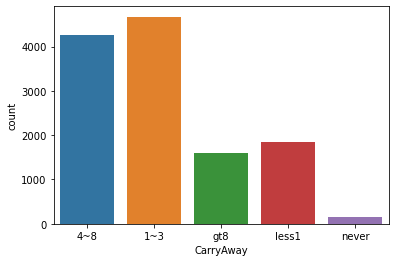

       RestaurantLessThan20  Ratio
1~3                    5376 42.384
4~8                    3580 28.225
less1                  2093 16.501
gt8                    1285 10.131
never                   220  1.734
##########################################


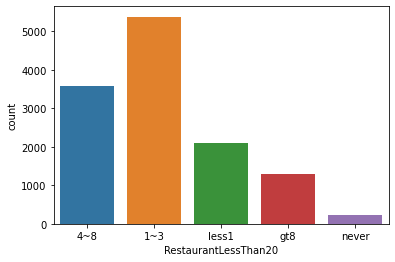

       Restaurant20To50  Ratio
less1              6077 47.911
1~3                3290 25.938
never              2136 16.840
4~8                 728  5.740
gt8                 264  2.081
##########################################


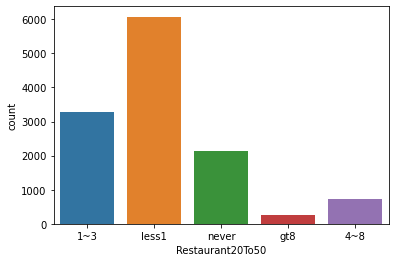

    temperature  Ratio
80         6528 51.466
55         3840 30.274
30         2316 18.259
##########################################


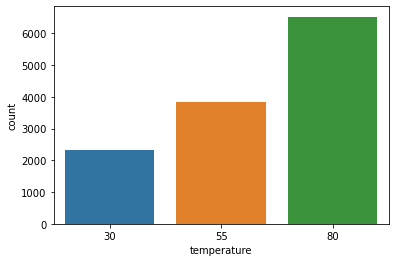

   has_children  Ratio
0          7431 58.586
1          5253 41.414
##########################################


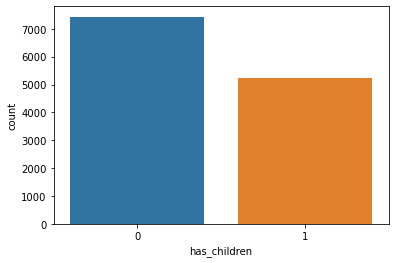

   toCoupon_GEQ5min   Ratio
1             12684 100.000
##########################################


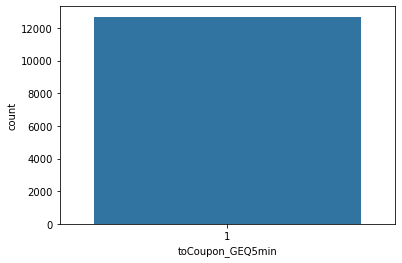

   toCoupon_GEQ15min  Ratio
1               7122 56.149
0               5562 43.851
##########################################


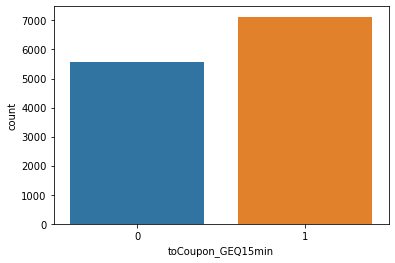

   toCoupon_GEQ25min  Ratio
0              11173 88.087
1               1511 11.913
##########################################


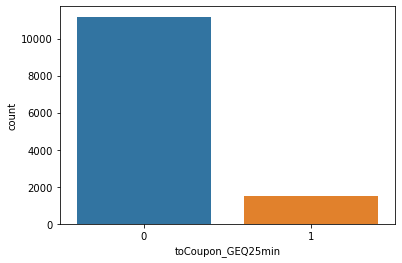

   direction_same  Ratio
0            9960 78.524
1            2724 21.476
##########################################


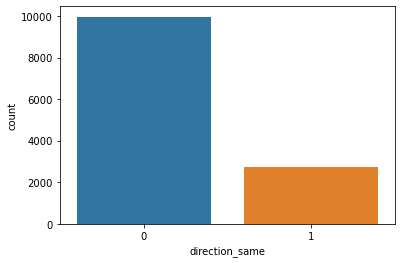

   direction_opp  Ratio
1           9960 78.524
0           2724 21.476
##########################################


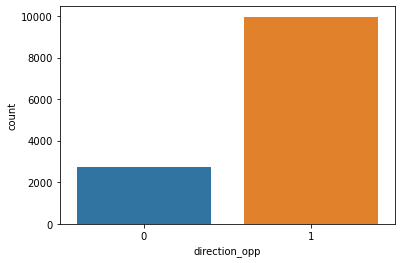

      Y  Ratio
1  7210 56.843
0  5474 43.157
##########################################


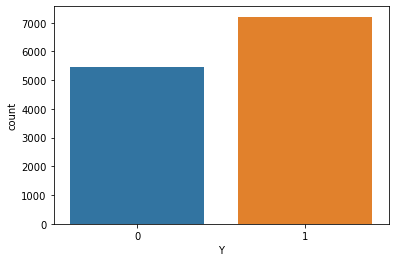

In [26]:
############################################################################################
#   STEP 3 - EDA : Make an analysis of numerical and categorical variables
############################################################################################

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for i in cat_cols:
    cat_summary(df, i, plot=True)  # We summarise categorical variables within themselves.
    

In [27]:
############################################################################################
#   STEP 4 - EDA : Analysis of the target variable along with each variable (feature)
############################################################################################

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({'TARGET MEAN':dataframe.groupby(categorical_col)[target].mean(),'TARGET COUNT':dataframe.groupby(categorical_col)[target].count()}))

for col in cat_cols:
    target_summary_with_cat(df,'Y', col)
    

                 TARGET MEAN  TARGET COUNT
destination                               
Home                   0.506          3237
No Urgent Place        0.634          6283
Work                   0.502          3164
           TARGET MEAN  TARGET COUNT
passanger                           
Alone            0.526          7305
Friend(s)        0.673          3298
Kid(s)           0.505          1006
Partner          0.595          1075
         TARGET MEAN  TARGET COUNT
weather                           
Rainy          0.463          1210
Snowy          0.470          1405
Sunny          0.595         10069
      TARGET MEAN  TARGET COUNT
time                           
10AM        0.608          2275
10PM        0.508          2006
2PM         0.662          2009
6PM         0.585          3230
7AM         0.502          3164
                       TARGET MEAN  TARGET COUNT
coupon                                          
Bar                          0.410          2017
Carry out & Take 

In [28]:
# We notice that 'toCoupon_GEQ5min' has only one class which is '1'. This variable does not have any valuable information as well as
# it will not make any contribution to our model. So, we need to take this out from the dataset as follows:

df['toCoupon_GEQ5min'].value_counts() # Check the nbr of classes
df.shape # (12684, 26)


(12684, 26)

In [29]:
df.drop(['toCoupon_GEQ5min'], axis=1, inplace=True) # Remove the variable 'oCoupon_GEQ5min' from the dataset
df.shape # (12684, 25)


(12684, 25)

In [30]:
num_but_cat = [col for col in num_but_cat if 'toCoupon_GEQ5min' not in col]
# We also remove the variable from the 'num_but_cat' columns list

cat_cols = [col for col in cat_cols if 'toCoupon_GEQ5min' not in col]
# We also remove the variable from the 'cat_cols' columns list

In [31]:
############################################################################################
#   STEP 5 - EDA: Make an analysis of outliers
############################################################################################
# No real numerical variable exists to investigate for outliers.


In [32]:
############################################################################################
#   STEP 6 - EDA : Make an analysis of missing values
############################################################################################

df.isnull().sum()

# There are 12576 missing values in 'car' variable
# There are 107 missing values in 'Bar' variable
# There are 217 missing values in 'CoffeeHouse' variable
# There are 151 missing values in 'CarryAway' variable
# There are 130 missing values in 'RestaurantLessThan20' variable
# There are 189 missing values in 'Restaurant20To50' variable

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [33]:
df.isnull().sum().sum()  # Total missing values = 13370 in the dataset

13370

In [34]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100
    missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if na_name:
        return na_columns

missing_values_table(df, na_name=False)


                      n_miss  ratio
car                    12576 99.150
CoffeeHouse              217  1.710
Restaurant20To50         189  1.490
CarryAway                151  1.190
RestaurantLessThan20     130  1.020
Bar                      107  0.840


In [35]:
# As we see that 99% of 'car' variable is missing, we can safely remove this variable from the dataset as follows:

df1 = df.drop(['car'], axis=1) # We label new dataset as 'df1'
df1.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'],
      dtype='object')

In [36]:
cat_cols = [col for col in cat_cols if 'car' not in col]
# We also remove the 'car' variable from the 'cat_cols' columns list

# For the rest of the variables, the ratio of missing values is around % 0.8 - 1.7 so, I would prefer to impute
# these missing values with the mode (the most seen value in the relevant variable)


In [37]:
##################################################################################################
#                             Feature Engineering
##################################################################################################
#   STEP 7 : Imputation missing values with Mode for Categorical Variables
##################################################################################################

cat_length = 26 # Nbr of classes threshold value for numerical but categorical variables. Please see 'grab_col_names function' above.

df2 = df1.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

# Fill the missing values with the mode. And we label new dataset as 'df2'


In [38]:
df2.isnull().sum() # Is there any missing value?
                   # No, all are imputed now.

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [39]:
############################################################################################
#   STEP 8 - FEATURE ENG. : Make an analysis of correlation
############################################################################################
# No numerical variable exists to demonstrate for correlation analysis.

df2.head()
num_but_cat # Categorical but numerically encoded variables
corr = df2[num_but_cat].corr()
corr


,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000,-0.020,-0.155,-0.216,0.097,-0.097,0.061
has_children,-0.020,1.000,0.078,-0.014,-0.032,0.032,-0.046
toCoupon_GEQ15min,-0.155,0.078,1.000,0.325,-0.304,0.304,-0.082
toCoupon_GEQ25min,-0.216,-0.014,0.325,1.000,-0.192,0.192,-0.104
direction_same,0.097,-0.032,-0.304,-0.192,1.000,-1.000,0.015
direction_opp,-0.097,0.032,0.304,0.192,-1.000,1.000,-0.015
Y,0.061,-0.046,-0.082,-0.104,0.015,-0.015,1.000


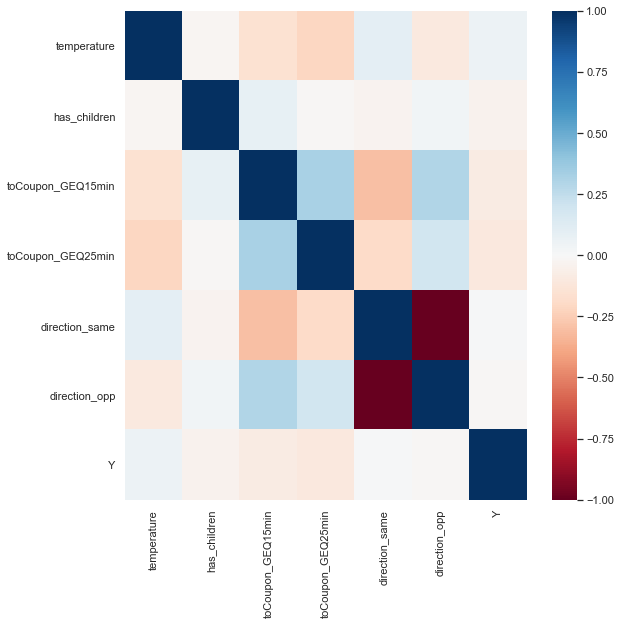

In [41]:
# Let us creat a heat map to visualize the correlations better..

sns.set(rc={'figure.figsize':(9,9)})
sns.heatmap(corr,cmap='RdBu')
plt.show()

In [42]:
# Here, we notice an -expected- negative correlation between the variables 'direction_same' and 'direction_opp'.
# It is logical as you drive either the same direction or the opposite direction while going to a destination.
# Again, we need to take out one of these two variables since the same information can be transferred by only one variable (or feature).
# I will remove 'direction_opp' variable from the dataset.

len(df2.columns) # 24
df2.drop(['direction_opp'], axis=1, inplace=True)


In [43]:
len(df2.columns) # 23

23

In [44]:
cat_cols = [col for col in cat_cols if 'direction_opp' not in col]
# We also remove the 'direction_opp' variable from the 'cat_cols' columns list


In [45]:
cat_cols

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'temperature',
 'has_children',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'Y']

In [46]:
############################################################################################
#   STEP 9 - FEATURE ENG.: Feature Extraction
############################################################################################
# We can extract new features from the variables of the dataset

# I create a new variable as 'NEW_SEX_CAT' to make a classification based on gender and age:
df2.loc[(df2['gender'] == 'Male') & ((df2['age'] == 'below21') | (df2['age'] == '21')), 'NEW_SEX_CAT'] = 'youngmale'
df2.loc[(df2['gender'] == 'Male') & (df2['age'].isin(['26','31','36','41','46'])), 'NEW_SEX_CAT'] = 'maturemale'
df2.loc[(df2['gender'] == 'Male') & (df2['age'] == '50plus'), 'NEW_SEX_CAT'] = 'seniormale'
df2.loc[(df2['gender'] == 'Female') & ((df2['age'] == 'below21') | (df2['age'] == '21')), 'NEW_SEX_CAT'] = 'youngfemale'
df2.loc[(df2['gender'] == 'Female') & (df2['age'].isin(['26','31','36','41','46'])), 'NEW_SEX_CAT'] = 'maturefemale'
df2.loc[(df2['gender'] == 'Female') & (df2['age'] == '50plus'), 'NEW_SEX_CAT'] = 'seniorfemale'


In [47]:
df2['NEW_SEX_CAT'].value_counts()  # We can see how many element for each new class that we created in the 'NEW_SEX_CAT' variable.


maturefemale    3925
maturemale      3771
youngmale       1728
youngfemale     1472
seniorfemale    1114
seniormale       674
Name: NEW_SEX_CAT, dtype: int64

In [48]:
############################################################################################
#   STEP 10 : ReCheck missing values and outliers
###########################################################################################
# We added new variables, so we need to retrieve again all column names with 'grab_col_names function'

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df2)
df2.isnull().sum()

Observations: 12684
Variables: 24
cat_cols: 24
num_cols: 0
cat_but_car: 0
num_but_cat: 6


destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
NEW_SEX_CAT             0
dtype: int64

In [49]:
############################################################################################
#   STEP 11 - FEATURE ENG.: Standardisation
############################################################################################
# No numerical variable exists, so we would not use this step.

In [51]:
############################################################################################
#   STEP 12 - FEATURE ENG.: Encode Categorical Variables
############################################################################################
# We need to take out target variable 'Y' from the list of categorical columns
# This is required for encoding as we will not encode the target variable 'Y'.

cat_cols
len(cat_cols) # 24
cat_cols = [col for col in df2.columns if col not in ['Y']]
# Take target variable ('Y') from the 'cat_cols' columns list


In [52]:
len(cat_cols) # 23. now it is okay.

23

In [53]:
df2.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,NEW_SEX_CAT
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,1,youngfemale
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,0,youngfemale
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,1,youngfemale
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0,youngfemale
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0,youngfemale


In [54]:
# Our one-hot encoder function
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [55]:
df2.shape # (12684,24)

(12684, 24)

In [56]:
df2[cat_cols].head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,NEW_SEX_CAT
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,youngfemale
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,youngfemale
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,youngfemale
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,youngfemale
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,youngfemale


In [57]:
df2 = one_hot_encoder(df2,cat_cols,drop_first=True)
df2.shape # (12684,97)

(12684, 97)

In [58]:
# After having applied encoding operation to the dataset, we increased the total nbr of variables (features or columns) as expected.
# So, we will be able to evaluate the impact of each class (in each variable) on the target variable 'Y'.
# On the other hand, the encoding operation is also a requirement before applying any ML algorithms to the dataset.

df2.head()


,Y,destination_No Urgent Place,destination_Work,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,weather_Sunny,temperature_55,temperature_80,time_10PM,time_2PM,time_6PM,time_7AM,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20),expiration_2h,gender_Male,age_26,age_31,age_36,age_41,age_46,age_50plus,age_below21,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,has_children_1,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,Bar_4~8,Bar_gt8,Bar_less1,Bar_never,CoffeeHouse_4~8,CoffeeHouse_gt8,CoffeeHouse_less1,CoffeeHouse_never,CarryAway_4~8,CarryAway_gt8,CarryAway_less1,CarryAway_never,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_1,toCoupon_GEQ25min_1,direction_same_1,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [59]:
df2.columns


Index(['Y', 'destination_No Urgent Place', 'destination_Work',
       'passanger_Friend(s)', 'passanger_Kid(s)', 'passanger_Partner',
       'weather_Snowy', 'weather_Sunny', 'temperature_55', 'temperature_80',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM',
       'coupon_Carry out & Take away', 'coupon_Coffee House',
       'coupon_Restaurant(20-50)', 'coupon_Restaurant(<20)', 'expiration_2h',
       'gender_Male', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'maritalStatus_Married partner',
       'maritalStatus_Single', 'maritalStatus_Unmarried partner',
       'maritalStatus_Widowed', 'has_children_1', 'education_Bachelors degree',
       'education_Graduate degree (Masters or Doctorate)',
       'education_High School Graduate', 'education_Some High School',
       'education_Some college - no degree',
       'occupation_Arts Design Entertainment Sports & Media',
       'occupation_Building & Grounds Cleaning & Maintenance',
      

In [60]:
############################################################################################
#   STEP 13 - MODELING : Applying all classification algorithms
############################################################################################

y = df2['Y']
X = df2.drop(['Y'], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

In [63]:
# All classification models to be used
models = [('LR', LogisticRegression(random_state=33)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=33)),
          ('RF', RandomForestClassifier(random_state=33)),
          ('SVM', SVC(gamma='auto', random_state=33)),
          ('GBM', GradientBoostingClassifier(random_state=33)),
          ('LightGBM', LGBMClassifier(random_state=33)),
          ('CatBoost', CatBoostClassifier(verbose=False, random_state=33))]


In [64]:
# Let us see test errors and confusion matrix of all models
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)
    print(classification_report(y_test, y_pred))

LR: (0.680725)
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1112
           1       0.70      0.77      0.73      1425

    accuracy                           0.68      2537
   macro avg       0.68      0.67      0.67      2537
weighted avg       0.68      0.68      0.68      2537

KNN: (0.650769)
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      1112
           1       0.68      0.72      0.70      1425

    accuracy                           0.65      2537
   macro avg       0.64      0.64      0.64      2537
weighted avg       0.65      0.65      0.65      2537

CART: (0.698857)
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1112
           1       0.73      0.73      0.73      1425

    accuracy                           0.70      2537
   macro avg       0.69      0.69      0.69      2537
weighted avg       0.70   

In [65]:
# Model Accuracies
#######################
# Random Forest = 75%
# SVM = 70%
# GBM = 71%
# LightGBM = 74%
# CatBoost = 76%

In [66]:
# Let us calculate errors with the Cross Validation Technique

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=3, scoring=["roc_auc"])
    print(f"AUC: {round(cv_results['test_roc_auc'].mean(),4)} ({name}) ")

AUC: 0.6914 (LR) 
AUC: 0.5657 (KNN) 
AUC: 0.5872 (CART) 
AUC: 0.6865 (RF) 
AUC: 0.7108 (SVM) 
AUC: 0.7115 (GBM) 
AUC: 0.7079 (LightGBM) 
AUC: 0.7166 (CatBoost) 


In [67]:
# Area under ROC Curve 
#######################
# RF AUC       = 68%
# SVM AUC      = 71%
# GBM AUC      = 71%
# LightGBM AUC = 70%
# CatBoost AUC = 71%

In [68]:
#############################################################################################
# STEP 14 - MODELING : Automated Hyperparameter Optimization
############################################################################################

# We will tune three classifiers; CatBoost, RF and LightGBM

catboost_params = {'iterations': [30, 100, 500],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'depth':  [6,8,11],
                   'bootstrap_type': ['Bayesian', 'Bernoulli','No']}

rf_params = {'max_depth': [5, 8, 15, None],
             'max_features': [5, 7, 'auto'],
             'min_samples_split': [8, 15, 20],
             'n_estimators': [200, 500, 1000]}


lightgbm_params = {'learning_rate': [0.01, 0.1],
                   'n_estimators': [300, 500, 1500],
                   'colsample_bytree': [0.5, 0.7, 1]}


In [69]:
classifiers = [('CatBoost', CatBoostClassifier(verbose=False, random_state=33), catboost_params),
               ('RF', RandomForestClassifier(random_state=33), rf_params),
               ('LightGBM', LGBMClassifier(random_state=33), lightgbm_params)]


best_models = {}

In [70]:
for name, classifier, params in classifiers:
    print(f"########## {name} ##########")
    cv_results = cross_validate(classifier, X, y, cv=3, scoring=["roc_auc"])
    print(f"AUC (Before): {round(cv_results['test_roc_auc'].mean(),4)}")


    gs_best = GridSearchCV(classifier, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)
    final_model = classifier.set_params(**gs_best.best_params_)

    cv_results = cross_validate(final_model, X, y, cv=3, scoring=["roc_auc"])
    print(f"AUC (After): {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## CatBoost ##########
AUC (Before): 0.7166
AUC (After): 0.7297
CatBoost best params: {'bootstrap_type': 'No', 'depth': 8, 'iterations': 100, 'learning_rate': 0.01}

########## RF ##########
AUC (Before): 0.6865
AUC (After): 0.7038
RF best params: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 1000}

########## LightGBM ##########
AUC (Before): 0.7079
AUC (After): 0.7279
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



In [71]:
# With help of the hyperparameter tuning, we could reach:

# CatBoost  AUC 71.6% => 72.9%
# RF        AUC 68.6% => 70.3%
# LigthGBM  AUC 70.7% => 72.7%


In [75]:
#############################################################################################
# STEP 15 - MODELING : Feature Importance
#############################################################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_, 'Feature':features.columns})
    plt.figure(figsize=(15,15))
    sns.set(font_scale=1)
    sns.barplot(x='Value',y='Feature', data=feature_imp.sort_values(by='Value',
                                                                    ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [76]:
catboost_model = CatBoostClassifier(verbose=False, random_state=33).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred)) # Accuracy : 76%

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1112
           1       0.76      0.84      0.80      1425

    accuracy                           0.76      2537
   macro avg       0.76      0.75      0.76      2537
weighted avg       0.76      0.76      0.76      2537



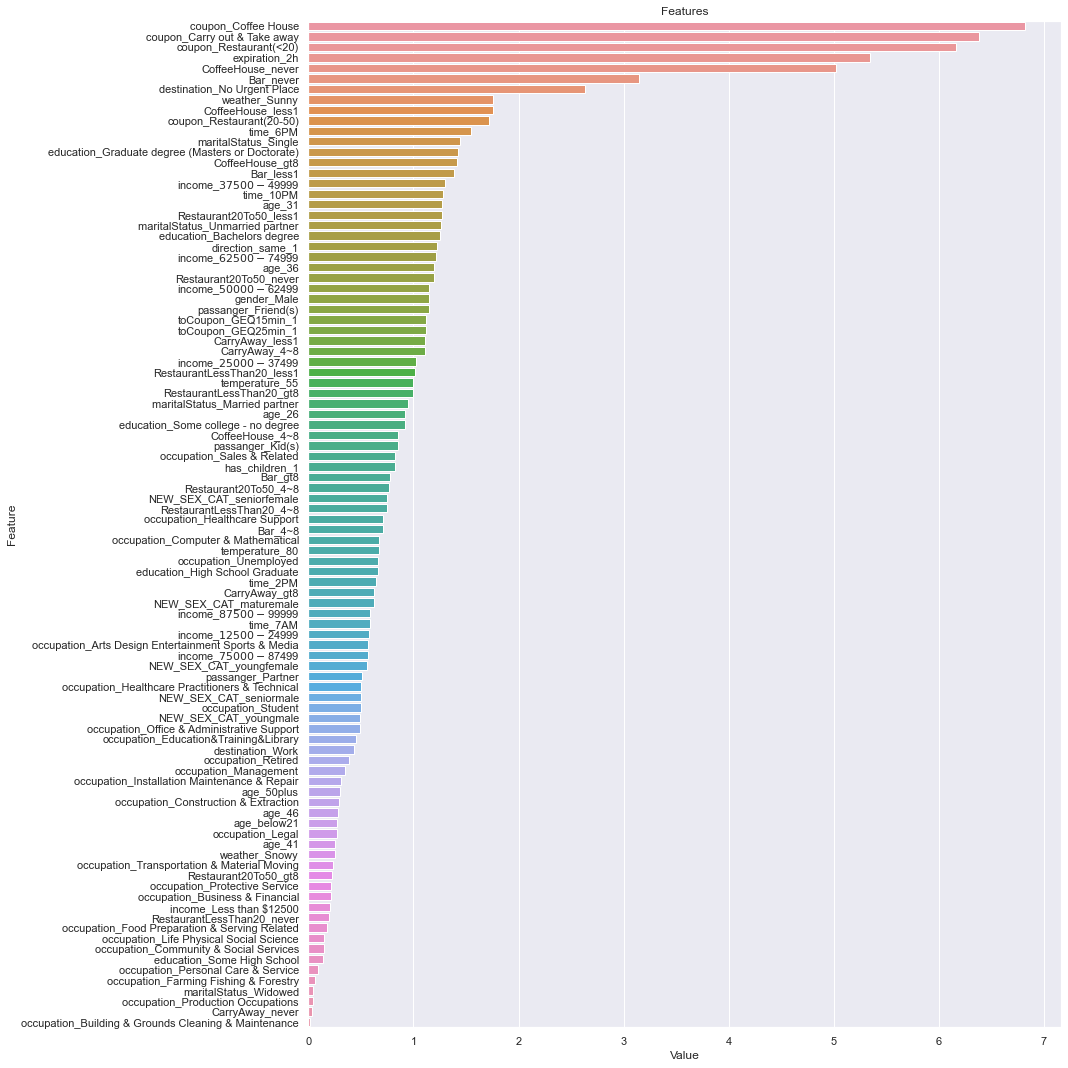

In [77]:
plot_importance(catboost_model, X) # Feature importance graph for CatBoost Model